# Predicting car prices

We'll be using a k-nearest neighbours model to predict a car's market price using its attributes, such as the motor's displacement, the weight of the car, the miles per gallon, how fast the car accelerates, and more. The data set can be downloaded [here](https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data), and more details about it can be found [here](https://archive.ics.uci.edu/ml/datasets/automobile).

## Understanding the data

In [2]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
cars = pd.read_csv('imports-85.data',header=None)
cars.columns = ['symboling','normalized_losses','make','fuel_type','aspiration','num_doors','body_style','drive_wheels','engine_location','wheel_base','length','width','height','curb_weight','engine_type','num_cylinders','engine_size','fuel_system','bore','stroke','compression_ratio','horsepower','peak_rpm','city_mpg','highway_mpg','price']
cars.head(5)

,symboling,normalized_losses,make,fuel_type,aspiration,num_doors,body_style,drive_wheels,engine_location,wheel_base,...,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


Looking at the data, out target column is 'price', as we're trying to predict prices. 

The first two columns contain the following info:

- its assigned insurance risk rating. This corresponds to the degree to which the auto is more risky than its price indicates. Cars are initially assigned a risk factor symbol associated with its price. Then, if it is more risky (or less), this symbol is adjusted by moving it up (or down) the scale. Actuarians call this process "symboling". A value of +3 indicates that the auto is risky, -3 that it is probably pretty safe.
- its normalized losses in use as compared to other cars. This is the relative average loss payment per insured vehicle year. This value is normalized for all autos within a particular size classification (two-door small, station wagons, sports/speciality, etc...), and represents the average loss per car per year.


Some numeric columns that we could use as features for our model include:

- normalized losses
- length, width, height
- engine size
- compression_ratio
- horsepower
- peak_rpm
- city_mpg
- highway_mpg


## Preparing the data

We usually can't have any missing values if we want to use them for predictive modeling. We also want the scale of all columns to be aligned so that no single column skews the calculation of euclidean distance. So we'll start by dropping non-numeric columns, replacing missing values and rescaling the numeric columns.

In [4]:
# Keeping numeric columns
continuous_values_cols = ['normalized_losses', 'wheel_base', 'length', 'width', 'height', 'curb_weight', 'engine_size', 'bore', 'stroke', 'compression_ratio', 'horsepower', 'peak_rpm', 'city_mpg', 'highway_mpg', 'price']
numeric_cars = cars[continuous_values_cols]

# Replacing missing values with nan
numeric_cars = numeric_cars.replace('?',np.nan)

# Converting numeric columns to numeric data types
# col_subset = ['normalized_losses','bore','stroke','horsepower','peak_rpm','price']
numeric_cars = numeric_cars.astype({'normalized_losses':'float64','bore':'float64','stroke':'float64','horsepower':'float64','peak_rpm':'float64','price':'float64'})
numeric_cars.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 15 columns):
normalized_losses    164 non-null float64
wheel_base           205 non-null float64
length               205 non-null float64
width                205 non-null float64
height               205 non-null float64
curb_weight          205 non-null int64
engine_size          205 non-null int64
bore                 201 non-null float64
stroke               201 non-null float64
compression_ratio    205 non-null float64
horsepower           203 non-null float64
peak_rpm             203 non-null float64
city_mpg             205 non-null int64
highway_mpg          205 non-null int64
price                201 non-null float64
dtypes: float64(11), int64(4)
memory usage: 24.1 KB


We can see that 7 columns have some missing values, and that some of these are feature or target columns. For the price, horsepower and peak_rpm columns, we'll drop the rows that contain missing values as we will only lose 6 rows. 

We'll replace the missing values in the normalized-losses column using the average values in that column, as getting rid of about 40 rows would substantially affect the dataset, and we want to keep the column as it probably affects car prices.

In [5]:
# dropping the rows that contain missing values in the 3 columns
numeric_cars = numeric_cars.dropna(subset=['price','horsepower','peak_rpm'])


In [6]:
# Replace missing values in other columns using column means.
numeric_cars = numeric_cars.fillna(numeric_cars.mean())
numeric_cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199 entries, 0 to 204
Data columns (total 15 columns):
normalized_losses    199 non-null float64
wheel_base           199 non-null float64
length               199 non-null float64
width                199 non-null float64
height               199 non-null float64
curb_weight          199 non-null int64
engine_size          199 non-null int64
bore                 199 non-null float64
stroke               199 non-null float64
compression_ratio    199 non-null float64
horsepower           199 non-null float64
peak_rpm             199 non-null float64
city_mpg             199 non-null int64
highway_mpg          199 non-null int64
price                199 non-null float64
dtypes: float64(11), int64(4)
memory usage: 24.9 KB


In [7]:
# normalize the columns so all values range from 0 to 1
price = numeric_cars['price']
numeric_cars = (numeric_cars - numeric_cars.min())/(numeric_cars.max()-numeric_cars.min())
numeric_cars['price'] = price
numeric_cars.reset_index(inplace=True,drop=True)
numeric_cars.head(5)

,normalized_losses,wheel_base,length,width,height,curb_weight,engine_size,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,0.298429,0.058309,0.413433,0.324786,0.083333,0.411171,0.260377,0.664286,0.290476,0.1250,0.294393,0.346939,0.222222,0.289474,13495.0
1,0.298429,0.058309,0.413433,0.324786,0.083333,0.411171,0.260377,0.664286,0.290476,0.1250,0.294393,0.346939,0.222222,0.289474,16500.0
2,0.298429,0.230321,0.449254,0.444444,0.383333,0.517843,0.343396,0.100000,0.666667,0.1250,0.495327,0.346939,0.166667,0.263158,16500.0
3,0.518325,0.384840,0.529851,0.504274,0.541667,0.329325,0.181132,0.464286,0.633333,0.1875,0.252336,0.551020,0.305556,0.368421,13950.0
4,0.518325,0.373178,0.529851,0.521368,0.541667,0.518231,0.283019,0.464286,0.633333,0.0625,0.313084,0.551020,0.138889,0.157895,17450.0


In [8]:
# alternative method 
# from sklearn import preprocessing

# x = numeric_cars.iloc[:,0:-1].values #returns a numpy array
# price = numeric_cars['price']
# min_max_scaler = preprocessing.MinMaxScaler()
# x_scaled = min_max_scaler.fit_transform(x)
# numeric_cars_scaled = pd.DataFrame(x_scaled)
# numeric_cars_scaled['price'] = price
# numeric_cars_scaled.columns = ['normalized_losses', 'wheel_base', 'length', 'width', 'height', 'curb_weight', 'engine_size', 'bore', 'stroke', 'compression_ratio', 'horsepower', 'peak_rpm', 'city_mpg', 'highway_mpg', 'price']
# numeric_cars_scaled.head(5)

## Starting with a univariate model

We'll start with a univariate model and the default k value of 5.

In [9]:
def knn_train_test(features, target, df):
    knn = KNeighborsRegressor()
    np.random.seed(1)
        
    # Randomize order of rows in data frame.
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)

    # Divide number of rows in half and round.
    last_train_row = int(len(rand_df) / 2)
    
    # Select the first half and set as training set.
    # Select the second half and set as test set.
    train_df = rand_df.iloc[0:last_train_row]
    test_df = rand_df.iloc[last_train_row:]
    
    # Fit a KNN model using default k value.
    knn.fit(train_df[[features]], train_df[target])
    
    # Make predictions using model
    predicted_labels = knn.predict(test_df[[features]])

    # Calculate and return RMSE
    mse = mean_squared_error(test_df[target], predicted_labels)
    rmse = np.sqrt(mse)
    return rmse

In [10]:
rmse_results = {}
train_cols = numeric_cars.columns.drop('price')

# Run the model using each numeric feature column and store the rmse
for col in train_cols:
    rmse_val = knn_train_test(col, 'price', numeric_cars)
    rmse_results[col] = rmse_val

# Create a Series object from the dictionary so 
# we can easily view the results, sort, etc
rmse_results_series = pd.Series(rmse_results)
rmse_results_series.sort_values()

engine_size          3002.471310
horsepower           4002.994385
curb_weight          4498.477734
highway_mpg          4614.991413
width                4780.444828
city_mpg             4850.183519
wheel_base           5596.489233
length               5710.745533
compression_ratio    6386.194053
bore                 7065.850338
stroke               7480.509072
peak_rpm             7532.973147
normalized_losses    7679.745159
height               8124.525250
dtype: float64

The model performed the best using the engine size column, withe lowest root mean squared value of about 3002.

### Varying the k value

In [11]:
def knn_train_test_k(features, target, df, k):
    knn = KNeighborsRegressor(n_neighbors = k)
    np.random.seed(1)
        
    # Randomize order of rows in data frame.
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)

    # Divide number of rows in half and round.
    last_train_row = int(len(rand_df) / 2)
    
    # Select the first half and set as training set.
    # Select the second half and set as test set.
    train_df = rand_df.iloc[0:last_train_row]
    test_df = rand_df.iloc[last_train_row:]
    
    # Fit a KNN model using default k value.
    knn.fit(train_df[[features]], train_df[target])
    
    # Make predictions using model
    predicted_labels = knn.predict(test_df[[features]])

    # Calculate and return RMSE
    mse = mean_squared_error(test_df[target], predicted_labels)
    rmse = np.sqrt(mse)
    return rmse

In [12]:
k_vals = [1,3,5,7,9]
train_cols = numeric_cars.columns.drop('price')
k_rmse_results = {}

# Rerun the model on each column, testing the different k values
for col in train_cols:
    k_rmses = {}
    for val in k_vals:
        rmse_val = knn_train_test_k(col, 'price', numeric_cars, val)
        k_rmses[val] = rmse_val
    k_rmse_results[col] = k_rmses
    
k_rmse_results

{'bore': {1: 10855.997766212004,
  3: 8045.945694088559,
  5: 7065.850338267858,
  7: 6870.051527641476,
  9: 6747.507898796487},
 'city_mpg': {1: 5912.784910682952,
  3: 4647.4389406066075,
  5: 4850.183519414498,
  7: 4833.401953709462,
  9: 4849.497569521004},
 'compression_ratio': {1: 8988.663193156144,
  3: 6318.3142937372495,
  5: 6386.194052641996,
  7: 6494.309211603523,
  9: 6746.250030732665},
 'curb_weight': {1: 5286.753343972083,
  3: 5085.88691915623,
  5: 4498.477734211874,
  7: 4406.903745979316,
  9: 4690.252926331687},
 'engine_size': {1: 3681.6973490497558,
  3: 2912.835901660099,
  5: 3002.471309771336,
  7: 3454.9656391864714,
  9: 3636.263521735763},
 'height': {1: 9617.192068894123,
  3: 8387.723032504113,
  5: 8124.52524961305,
  7: 7617.552537048489,
  9: 7901.203586218},
 'highway_mpg': {1: 5408.289342296694,
  3: 4433.633667395928,
  5: 4614.991413166443,
  7: 4612.898328400841,
  9: 4893.616590701618},
 'horsepower': {1: 4433.762825185849,
  3: 3943.951694965

In [13]:
k_rmses_df = pd.DataFrame(k_rmse_results)
k_rmses_df


,bore,city_mpg,compression_ratio,curb_weight,engine_size,height,highway_mpg,horsepower,length,normalized_losses,peak_rpm,stroke,wheel_base,width
1,10855.997766,5912.784911,8988.663193,5286.753344,3681.697349,9617.192069,5408.289342,4433.762825,5218.287991,7613.159872,7283.953434,9178.390552,5010.324504,4770.480632
3,8045.945694,4647.438941,6318.314294,5085.886919,2912.835902,8387.723033,4433.633667,3943.951695,5262.149601,7498.919737,8416.596864,7070.843657,5256.323928,4967.618728
5,7065.850338,4850.183519,6386.194053,4498.477734,3002.471310,8124.525250,4614.991413,4002.994385,5710.745533,7679.745159,7532.973147,7480.509072,5596.489233,4780.444828
7,6870.051528,4833.401954,6494.309212,4406.903746,3454.965639,7617.552537,4612.898328,4493.637017,5508.856991,7964.344142,7341.247930,7380.386309,5472.449670,4615.832438
9,6747.507899,4849.497570,6746.250031,4690.252926,3636.263522,7901.203586,4893.616591,4670.394440,5510.848742,7701.051011,7146.851065,7632.008784,5820.559939,4760.123487


In [14]:
k_rmses_df.reset_index(inplace=True)
k_rmses_df            

,index,bore,city_mpg,compression_ratio,curb_weight,engine_size,height,highway_mpg,horsepower,length,normalized_losses,peak_rpm,stroke,wheel_base,width
0,1,10855.997766,5912.784911,8988.663193,5286.753344,3681.697349,9617.192069,5408.289342,4433.762825,5218.287991,7613.159872,7283.953434,9178.390552,5010.324504,4770.480632
1,3,8045.945694,4647.438941,6318.314294,5085.886919,2912.835902,8387.723033,4433.633667,3943.951695,5262.149601,7498.919737,8416.596864,7070.843657,5256.323928,4967.618728
2,5,7065.850338,4850.183519,6386.194053,4498.477734,3002.471310,8124.525250,4614.991413,4002.994385,5710.745533,7679.745159,7532.973147,7480.509072,5596.489233,4780.444828
3,7,6870.051528,4833.401954,6494.309212,4406.903746,3454.965639,7617.552537,4612.898328,4493.637017,5508.856991,7964.344142,7341.247930,7380.386309,5472.449670,4615.832438
4,9,6747.507899,4849.497570,6746.250031,4690.252926,3636.263522,7901.203586,4893.616591,4670.394440,5510.848742,7701.051011,7146.851065,7632.008784,5820.559939,4760.123487


/dataquest/system/env/python3/lib/python3.4/site-packages/pandas/plotting/_core.py:1716: UserWarning:

Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access



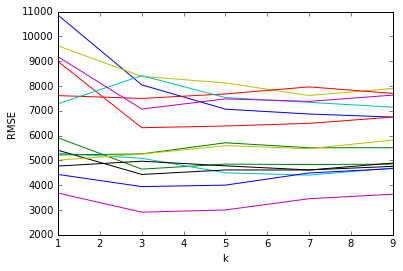

In [15]:
# k_rmses_df.plot.line(x='index', y=['normalized_losses', 'wheel_base', 'length', 'width', 'height', 'curb_weight', 'engine_size', 'bore', 'stroke', 'compression_ratio', 'horsepower', 'peak_rpm', 'city_mpg', 'highway_mpg'])
plot_features = k_rmses_df.columns.drop('index')
k_rmses_df.plot.line(x='index', y=plot_features)
plt.xlabel('k')
plt.ylabel('RMSE')
plt.legend('',frameon=False)


## Multivariate model

Now we'll try a multivariate model with the default k value of 5.

In [27]:
# Finding the mean RMSE values across k values from the previous step
mean_rmses = k_rmses_df.iloc[:,1:].mean()
mean_rmses = mean_rmses.sort_values()
mean_rmses = mean_rmses.reset_index()
mean_rmses.columns = ['features','mean rmse']
mean_rmses


,features,mean rmse
0,engine_size,3337.646744
1,horsepower,4308.948072
2,width,4778.900023
3,highway_mpg,4792.685868
4,curb_weight,4793.654934
5,city_mpg,5018.661379
6,wheel_base,5431.229455
7,length,5442.177772
8,compression_ratio,6986.746156
9,peak_rpm,7544.324488


In [ ]:
# Modifying the earlier function to take in a list of features
def knn_train_test(features, target, df):
    knn = KNeighborsRegressor()
    np.random.seed(1)
        
    # Randomize order of rows in data frame.
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)

    # Divide number of rows in half and round.
    last_train_row = int(len(rand_df) / 2)
    
    # Select the first half and set as training set.
    # Select the second half and set as test set.
    train_df = rand_df.iloc[0:last_train_row]
    test_df = rand_df.iloc[last_train_row:]
    
    # Fit a KNN model using default k value.
    knn.fit(train_df[features], train_df[target])
    
    # Make predictions using model
    predicted_labels = knn.predict(test_df[features])

    # Calculate and return RMSE
    mse = mean_squared_error(test_df[target], predicted_labels)
    rmse = np.sqrt(mse)
    return rmse

In [37]:
num_features = [2,3,4,5]
multi_rmses = {}

for n in num_features:
    features = list(mean_rmses['features'][0:n])
    multi_rmse = knn_train_test(features, 'price', numeric_cars)
    multi_rmses[str(n)+' best features'] = multi_rmse

multi_rmses

{'2 best features': 2952.6868472630144,
 '3 best features': 3557.5009334643896,
 '4 best features': 3555.7662080626174,
 '5 best features': 3536.13838071985}

### Optimising the multivariate model with hyperparameter tuning

We started with a univariate model and we varied the hyperparameters and took the average to see which features are best. Now that we've tested a multivariate model with different combinations of the best individual features, we'll optimise the model by varying the hyperparameter value for the top 3 combinations of features.

In [39]:
# Modifying the earlier function to take in a list of features
def knn_train_test_k(features, target, df, k):
    knn = KNeighborsRegressor(n_neighbors = k)
    np.random.seed(1)
        
    # Randomize order of rows in data frame.
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)

    # Divide number of rows in half and round.
    last_train_row = int(len(rand_df) / 2)
    
    # Select the first half and set as training set.
    # Select the second half and set as test set.
    train_df = rand_df.iloc[0:last_train_row]
    test_df = rand_df.iloc[last_train_row:]
    
    # Fit a KNN model using default k value.
    knn.fit(train_df[features], train_df[target])
    
    # Make predictions using model
    predicted_labels = knn.predict(test_df[features])

    # Calculate and return RMSE
    mse = mean_squared_error(test_df[target], predicted_labels)
    rmse = np.sqrt(mse)
    return rmse

In [52]:
# Running the model with k ranging from 1 to 25
k_range = range(1,26)
num_features = [2,4,5]
multi_k_rmses = {}

for n in num_features:
    features = list(mean_rmses['features'][0:n])
    k_rmses = {}
    for k in k_range:
        multi_rmse = knn_train_test_k(features,'price',numeric_cars,k)
        k_rmses[k] = multi_rmse
    multi_k_rmses[str(n)+' best features'] = k_rmses


/dataquest/system/env/python3/lib/python3.4/site-packages/pandas/plotting/_core.py:1716: UserWarning:

Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access



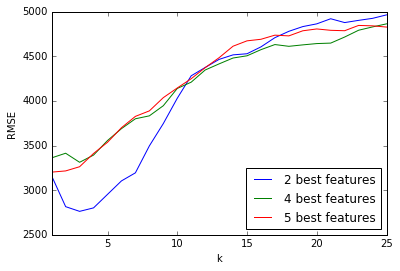

In [54]:
# plotting the RMSE values
multi_k_rmses_df = pd.DataFrame(multi_k_rmses)
multi_k_rmses_df.reset_index(inplace=True) 
plot_features = multi_k_rmses_df.columns.drop('index')
plot_features
multi_k_rmses_df.plot.line(x='index', y=plot_features)
plt.xlabel('k')
plt.ylabel('RMSE')

The optimal hyperparameter values for each model are:

- 2 best features: 3
- 4 best features: 3
- 5 best features: 1


In [82]:
multi_k_rmses_df

,index,2 best features,4 best features,5 best features
0,1,3158.316284,3361.889415,3202.146410
1,2,2815.183221,3413.578892,3215.557040
2,3,2762.557246,3312.168535,3262.511883
3,4,2801.543619,3392.816274,3411.088258
4,5,2952.686847,3555.766208,3536.138381
5,6,3103.581112,3688.865018,3699.442556
6,7,3194.084361,3799.582225,3826.515638
7,8,3495.554747,3832.318096,3887.931512
8,9,3745.596506,3945.804144,4036.164437
9,10,4029.014936,4139.098133,4144.223423


In [57]:
# alternative code for plotting:
# for k,v in k_rmse_results.items():
#     x = list(v.keys())
#     y = list(v.values())  
#     plt.plot(x,y, label="{}".format(k))
    
# plt.xlabel('k value')
# plt.ylabel('RMSE')
# plt.legend()

## K-fold cross validation

Now, we'll test the model using k-fold cross validation with the default k value to see if that improves performance. We'll test this using 2 features, as that produced the best results earlier on.

In [ ]:
for fold in num_folds:
    kf = KFold(fold, shuffle=True, random_state=1)
    model = KNeighborsRegressor()
    mses = cross_val_score(model, dc_listings[["accommodates"]], dc_listings["price"], scoring="neg_mean_squared_error", cv=kf)
    rmses = np.sqrt(np.absolute(mses))
    avg_rmse = np.mean(rmses)
    std_rmse = np.std(rmses)
    print(str(fold), "folds: ", "avg RMSE: ", str(avg_rmse), "std RMSE: ", str(std_rmse))

In [77]:
# Modifying the earlier function for k-fold cross validation
def knn_cross_val(features,target,df,fold):
    kf = KFold(fold, shuffle=True, random_state=1)
    mses = cross_val_score(model, df[features], df[target], scoring="neg_mean_squared_error", cv=kf)
    rmses = np.sqrt(np.absolute(mses))
    mean_rmse = np.mean(rmses)
    std_rmse = np.std(rmses)
    stats = [mean_rmse,std_rmse] 
    return stats

In [104]:
# running k-fold cross validation with different hyperparameters
num_folds = [2, 3, 4, 5]
k_range = range(1,6)
num_features = [2,4,5]
features_rmses = {}

for n in num_features:
    features = list(mean_rmses['features'][0:n])
    cross_rmses = {}
    for f in num_folds:
        folds_rmses = {}
        for k in k_range:
            model = KNeighborsRegressor(n_neighbors=k)
            multi_mean_rmse = knn_cross_val(features,'price',numeric_cars,f)
            folds_rmses[k] = multi_mean_rmse
        cross_rmses[str(f)+' folds'] = folds_rmses
    features_rmses[str(n) + ' features'] = cross_rmses

features_rmses


{'2 features': {'2 folds': {1: [3689.3239486429293, 258.8207270243645],
   2: [3489.8596946641105, 631.5322143273165],
   3: [3083.9244244020847, 278.3575827406171],
   4: [3109.820828313367, 280.99031865058623],
   5: [3286.224319258021, 359.5901587427454]},
  '3 folds': {1: [2851.2548238555087, 483.9358238954234],
   2: [2928.7196415346602, 263.2998089746422],
   3: [2977.763136229849, 283.1979739564127],
   4: [3104.376443209101, 214.71273266187234],
   5: [3281.11826457021, 149.28572148766267]},
  '4 folds': {1: [3035.838760948486, 580.4400427581181],
   2: [2910.444902543031, 701.3500117856241],
   3: [3049.403226468167, 773.1408141725028],
   4: [3019.2375238319123, 811.5342246776163],
   5: [3159.9535619917892, 803.0930140237621]},
  '5 folds': {1: [2931.480399681753, 497.79208717188334],
   2: [2723.447149176193, 467.59517014621616],
   3: [2828.6140680270796, 487.8897488101723],
   4: [2879.174165652451, 379.53625464652845],
   5: [2982.1536029629756, 480.99873701691513]}},
 '

Based on the data above, we get a different result for the best performing model:

- Using 5 features, 3 folds and a k value of 3

## Conclusion

We've tested out 2 different models in this project, both of which yielded slightly different results. 

Using test/train validation, we found that a model using 2 features - engine size and horsepower - and a k value of 3 produced the most accurate model with a RMSE of 2762.6.

Using k-fold cross validation, we found that a model using 5 features, 3 folds and a k value of 3 produced the most accurate model, with a mean RMSE of 2881.1, and a variance (std deviation of RMSE) of 161.3.

The optimal hyperparameters are the same in both cases, while the RMSE values are not too different, so if we needed to predict the prices of cars, we could test both models and average out the results.